In [19]:
import tiktoken
from typing import List
from dotenv import load_dotenv
from langchain_core.documents import Document
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

In [20]:
load_dotenv()

embeddings_model = OpenAIEmbeddings(model='text-embedding-ada-002')
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

recall_vector_store = InMemoryVectorStore(embedding=embeddings_model)

In [21]:
import uuid


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id


@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return memory


@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

In [22]:
memory_tools = [save_recall_memory, search_recall_memories]

In [23]:
class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]

In [24]:
# Define the prompt template for the agent
memory_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant with advanced long-term memory"
            " capabilities. Powered by a stateless LLM, you must rely on"
            " external memory to store information between conversations."
            " Utilize the available memory tools to store and retrieve"
            " important details that will help you better attend to the user's"
            " needs and understand their context.\n\n"
            "Memory Usage Guidelines:\n"
            "1. Actively use memory tools (save_core_memory, save_recall_memory)"
            " to build a comprehensive understanding of the user.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            "4. Update your mental model of the user with each new piece of"
            " information.\n"
            "5. Cross-reference new information with existing memories for"
            " consistency.\n"
            "6. Prioritize storing emotional context and personal values"
            " alongside facts.\n"
            "7. Use memory to anticipate needs and tailor responses to the"
            " user's style.\n"
            "8. Recognize and acknowledge changes in the user's situation or"
            " perspectives over time.\n"
            "9. Leverage memories to provide personalized examples and"
            " analogies.\n"
            "10. Recall past challenges or successes to inform current"
            " problem-solving.\n\n"
            "## Recall Memories\n"
            "Recall memories are contextually retrieved based on the current"
            " conversation:\n{recall_memories}\n\n"
            "## Instructions\n"
            "Engage with the user naturally, as a trusted colleague or friend."
            " There's no need to explicitly mention your memory capabilities."
            " Instead, seamlessly incorporate your understanding of the user"
            " into your responses. Be attentive to subtle cues and underlying"
            " emotions. Adapt your communication style to match the user's"
            " preferences and current emotional state. Use tools to persist"
            " information you want to retain in the next conversation. If you"
            " do call tools, all text preceding the tool call is an internal"
            " message. Respond AFTER calling the tool, once you have"
            " confirmation that the tool completed successfully.\n\n",
        ),
        ("placeholder", "{messages}"),
    ]
)

In [25]:
model_with_memory_tools = llm.bind_tools(memory_tools)
tokenizer = tiktoken.encoding_for_model("gpt-4o-mini-2024-07-18")

In [26]:
def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | model_with_tools
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )
    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    print('recall_memories', recall_memories)
    return {
        "recall_memories": recall_memories,
    }


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

In [36]:
def conversation_memory_loader():
    pass

def long_term_memory_loader():
    pass

def internet_search_tool():
    pass


In [32]:
def query_router(state: State) -> list[str]:
    """LLM decides whether to use conversation_memory, long_term_memory, internet_search"""
    query = state["input"]

    prompt = f"""
    You are a router. Given the user query, decide which sources are required.
    Options: 
      - CONVERSATION_MEMORY (recent chat context)
      - LONG_TERM_MEMORY (facts about user or history)
      - INTERNET_SEARCH (real-time or external info)

    You can return one or more, separated by commas.
    Query: {query}
    Answer:
    """

    result = llm.invoke(prompt).strip().upper()

    # Normalize output
    outputs = []
    if "CONVERSATION_MEMORY" in result:
        outputs.append("conversation_memory")
    if "LONG_TERM_MEMORY" in result:
        outputs.append("long_term_memory")
    if "INTERNET_SEARCH" in result:
        outputs.append("internet_search")

    # If none detected → direct agent
    if not outputs:
        outputs = ["agent"]
    return outputs


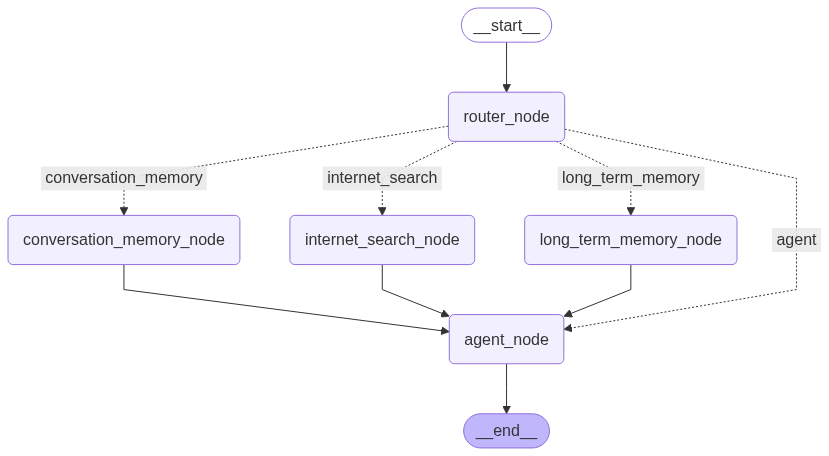

In [37]:
builder = StateGraph(State)

# Add nodes with descriptive names
builder.add_node("router_node", query_router)
builder.add_node("conversation_memory_node", conversation_memory_loader)
builder.add_node("long_term_memory_node", long_term_memory_loader)
builder.add_node("internet_search_node", internet_search_tool)
builder.add_node("agent_node", agent)

# Edges
builder.add_edge(START, "router_node")

# Router → conditional parallel edges
builder.add_conditional_edges(
    "router_node",
    query_router,
    {
        "conversation_memory": "conversation_memory_node",
        "long_term_memory": "long_term_memory_node",
        "internet_search": "internet_search_node",
        "agent": "agent_node",   # direct path if no sources needed
    }
)

# Each info source feeds into agent in parallel
builder.add_edge("conversation_memory_node", "agent_node")
builder.add_edge("long_term_memory_node", "agent_node")
builder.add_edge("internet_search_node", "agent_node")

# Final step
builder.add_edge("agent_node", END)

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))